<a href="https://colab.research.google.com/github/mateus-abrantes/rede-neural-convolucional-para-analise-de-sentimentos/blob/main/CNN_PARA_CLASSIFICA%C3%87%C3%83O_DE_SENTIMENTOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processamento de linguagem natural para analise de sentimentos de tweets usando uma rede neural convolucional**

REFERENCIAS


*   https://medium.com/data-hackers/redes-neurais-convolucionais-para-processamento-de-linguagem-natural-935488d6901b
*   https://github.com/orivaldosantana/nlp/blob/main/aulas_2020_2.md
*   https://github.com/ect-info/ml/blob/master/2020_2.md







# Importando as bibliotecas necessarias

In [51]:
import numpy as np
import re                     #Biblioteca para expressoes regulares
import pandas as pd
from bs4 import BeautifulSoup #Biblioteca para pre-processamento de textos
import seaborn as sns
import spacy as sp            #Biblioteca para processamento de linguagem natural
!python -m spacy download en_core_web_lg 
import en_core_web_lg 
import string
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


# Processamento dos dados

## Dados de treinamento

In [52]:
train_data_part1 = pd.read_csv('https://raw.githubusercontent.com/mateus-abrantes/rede-neural-convolucional-para-analise-de-sentimentos/main/dataset/train_part1.csv?token=AIX3SAENMOGLWLRO6P2224DASE4AQ')
train_data_part2 = pd.read_csv('https://raw.githubusercontent.com/mateus-abrantes/rede-neural-convolucional-para-analise-de-sentimentos/main/dataset/train_part2.csv?token=AIX3SAF4VMFQML57QWQML7DASE4AU')
train_data_part3 = pd.read_csv('https://raw.githubusercontent.com/mateus-abrantes/rede-neural-convolucional-para-analise-de-sentimentos/main/dataset/train_part3.csv?token=AIX3SAEKKWZW7PD7RPN65A3ASE4AW')
train_data_part4 = pd.read_csv('https://raw.githubusercontent.com/mateus-abrantes/rede-neural-convolucional-para-analise-de-sentimentos/main/dataset/train_part4.csv?token=AIX3SABSGOPEFXSV54XZHSTASE4A2')

In [53]:
train_data = train_data_part1.append(train_data_part2,ignore_index=True)
train_data = train_data.append(train_data_part3,ignore_index=True)
train_data = train_data.append(train_data_part4,ignore_index=True)
train_data.shape


(1600000, 6)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


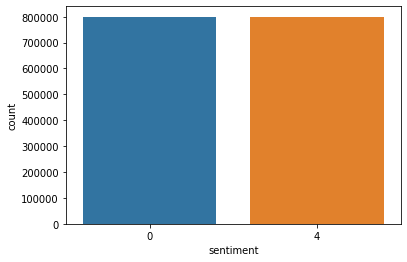

In [54]:
sns.countplot(train_data.sentiment)

# Pre-processamento

In [55]:
data = train_data
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

In [56]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [63]:
#Atributos previsores
X = data.iloc[:, 1].values
print(X.shape)
y = data.iloc[:, 0].values
print(y.shape)

(1600000,)
(1600000,)


In [64]:
#Usando 25% do dataset e com quantidade iguais de sentimentos
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.75, stratify = y)
print(X.shape)
print(y.shape)

(400000,)
(400000,)


## Tratamento dos textos

In [145]:
#PARTE EXTRA DE CODIGO PARA JÁ UTILIZAR OS 25% DE DADOS JÁ PROCESSADOS
#Recuperando dados já processados
data_x = pd.read_csv("https://raw.githubusercontent.com/mateus-abrantes/rede-neural-convolucional-para-analise-de-sentimentos/main/pre_processed_25%25_dataset/data_clean25.csv?token=AIX3SAC5MZJYX2UCM3OXMPDAS4GCS")
data_x = data_x.drop(['Unnamed: 0'],axis=1)
data_clean = data_x.iloc[:, 0].values
data_y = pd.read_csv("https://raw.githubusercontent.com/mateus-abrantes/rede-neural-convolucional-para-analise-de-sentimentos/main/pre_processed_25%25_dataset/data_label25.csv?token=AIX3SAG5CFQFXQT4WEN7OM3AS4GDS")
data_y = data_y.drop(['Unnamed: 0'],axis=1)
result = pd.concat([data_x, data_y], axis=1).dropna()
y = result.iloc[:, 1].values
data_clean = result.iloc[:, 0].values
print(len(data_clean))
print(len(y))

397274
397274


In [146]:
#Convertendo o valor do y de 4 para 1
y[y == 4] = 1
y

array([0, 0, 0, ..., 1, 0, 1])

In [ ]:
#TRECHO DE CODIGO PARA PROCESSAR OS DADOS DO DATASET

In [65]:
#Remoção de stop-words
nlp = en_core_web_lg.load() 
stop_words = sp.lang.en.STOP_WORDS
print(stop_words)
len(stop_words)

{'anywhere', 'three', 'still', 'us', 'here', 'else', 're', 'therefore', 'either', 'formerly', 'out', 'sixty', 'now', 'since', 'up', 'there', 'yet', 'doing', 'her', 'sometime', '’ve', 'this', 'six', 'see', 'serious', 'eight', 'also', 'because', '‘s', 'become', 'such', 'thence', 'done', 'during', 'made', 'where', 'twelve', 'elsewhere', 'about', 'somehow', 'therein', "'d", 'regarding', 'a', 'due', 'into', 'you', 'along', 'even', 'him', 'everyone', 'ours', 'upon', 'them', 'part', 'via', 'amount', "'s", 'very', 'whole', 'by', 'nor', "'ll", 'through', 'give', 'really', 'has', 'seem', 'several', 'four', 'hence', 'his', 'or', 'so', 'whoever', 'something', 'he', 'show', 'how', 'themselves', 'namely', 'same', 'sometimes', 'but', 'herein', 'any', 'among', 'besides', 'five', 'anyway', 'move', 'n‘t', 'ever', 'too', 'had', 'became', 'front', 'less', 'quite', 'various', 'cannot', 'himself', 'mine', 'none', 'name', 'they', 'nine', 'ourselves', '‘d', 'thereupon', 'hereby', 'before', 'could', 'over', 'a

326

In [79]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)             #Removendo citações de usuarios
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)   #Removendo url's
  tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)                 #Removendo numeros e simbolos desnecessarios
  tweet = re.sub(r" +", ' ', tweet)                        #Removendo espaços encadeados

  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation and len(word) != 1]
  words = ' '.join([str(element) for element in words])

  return words

In [ ]:
data_clean = [clean_tweets(tweet) for tweet in X]

In [ ]:
#Limpando dados vazios apos o processamento
if(data_clean.isna().sum() > 0){
    text_formated = DataFrame (data_clean,columns=['text_formated'])
    data_y = DataFrame (y,columns=['y'])
    result = result = pd.concat([data_x, data_y], axis=1).dropna()
    y = result.iloc[:, 1].values
    data_clean = result.iloc[:, 0].values
    print(len(data_clean))
    print(len(y))
}

## Tokenizando


In [147]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)
print(tokenizer.vocab_size)
print(tokenizer.subwords)
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

69895
['good_', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'work_', 'don_', 'today_', 'time_', 'know_', 'new_', 'll_', 'want_', 'think_', 'oh_', 'lol_', 'need_', 'night_', 'thanks_', 'home_', 'hope_', 've_', 'great_', 'miss_', 'feel_', 'morning_', 'twitter_', 'wish_', 'na_', 'gon_', 'getting_', 'bad_', 'haha_', 'tomorrow_', 'happy_', 'lol', 'day', 'sorry_', 'watching_', 'sleep_', 'sad_', 'yeah_', 'way_', 'come_', 'nice_', 'fun_', 's_', 'didn_', 'wait_', 'right_', 'today', 'hate_', 'bed_', 'hey_', 'people_', 'better_', 'school_', 'tonight_', 'little_', 'yes_', 'week_', 'having_', 'work', 'long_', 'wanna_', 'best_', 'ok_', 'days_', 'awesome_', 'feeling_', 'thank_', 'working_', 'let_', 'watch_', 'ur_', 'tired_', 'looking_', 'sure_', 'ready_', 'weekend_', 'won_', 'went_', 'find_', 'man_', 'thing_', 'life_', 'time', 'look_', 'sick_', 'trying_', 'pretty_', 'good', 'maybe_', 'omg_', 'phone_', 'friends_', 'cool_', 'guys_', 'love', 'tomorrow', 'finally_', 'big_', 'night', 'house_', 'dam

## Preenchimento

In [148]:
max_len = max([len(sentence) for sentence in data_inputs])
print(max_len)
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

41


# Divisão dos dados entre treinamento e teste

In [149]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        y,
                                                                        test_size=0.3,
                                                                        stratify = y)
print(train_inputs.shape)
print(train_labels.shape)
print(test_inputs.shape)
print(test_labels.shape)

(278091, 41)
(278091,)
(119183, 41)
(119183,)


# Construção do modelo

In [150]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Treinamento

## Configuração dos parâmetros

In [151]:
vocab_size = tokenizer.vocab_size
print(vocab_size)
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
print(nb_classes)
dropout_rate = 0.2
nb_epochs = 5

69895
2


## Treinamento

In [152]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [153]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [171]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

Latest checkpoint restored


In [155]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5
3911/3911 [==============================] - 779s 199ms/step - loss: 0.5280 - accuracy: 0.7295 - val_loss: 0.4746 - val_accuracy: 0.7720
Epoch 2/5
3911/3911 [==============================] - 777s 199ms/step - loss: 0.3743 - accuracy: 0.8330 - val_loss: 0.5048 - val_accuracy: 0.7709
Epoch 3/5
3911/3911 [==============================] - 776s 198ms/step - loss: 0.2175 - accuracy: 0.9098 - val_loss: 0.6784 - val_accuracy: 0.7441
Epoch 4/5
3911/3911 [==============================] - 783s 200ms/step - loss: 0.1195 - accuracy: 0.9520 - val_loss: 1.0255 - val_accuracy: 0.7464
Epoch 5/5
3911/3911 [==============================] - 774s 198ms/step - loss: 0.0814 - accuracy: 0.9669 - val_loss: 1.1935 - val_accuracy: 0.7295


'./ckpt-1'

## Avaliação

In [156]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

1863/1863 [==============================] - 43s 23ms/step - loss: 1.1830 - accuracy: 0.7266
[1.1830238103866577, 0.7266472578048706]


In [157]:
y_pred_test = Dcnn.predict(test_inputs)

In [158]:
y_pred_test

array([[0.9974488 ],
       [0.00914809],
       [0.00205788],
       ...,
       [0.54473364],
       [0.5915766 ],
       [0.99996245]], dtype=float32)

In [159]:
y_pred_test = (y_pred_test > 0.5)

In [160]:
y_pred_test

array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [161]:
test_labels

array([1, 0, 0, ..., 0, 1, 1])

In [162]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[38967, 20634],
       [11945, 47637]])

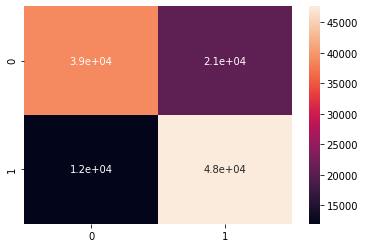

In [163]:
sns.heatmap(cm, annot=True)

In [164]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

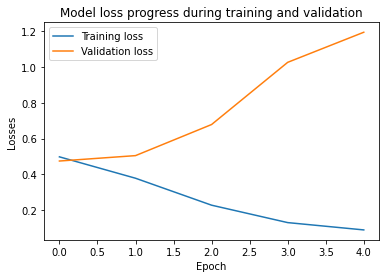

In [165]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

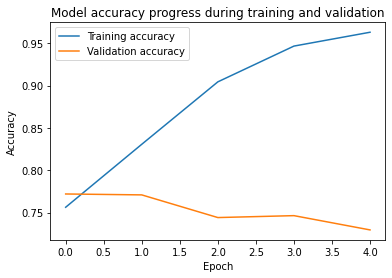

In [166]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Previsões

In [167]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[584, 54, 8546]

In [168]:
Dcnn(np.array([text]), training=False).numpy()

array([[0.00011615]], dtype=float32)

In [169]:
text2 = 'i love you'
text2 = tokenizer.encode(text2)
text2

[584, 7, 8546]

In [170]:
Dcnn(np.array([text2]), training=False).numpy()

array([[0.999974]], dtype=float32)